## Task 1. Each review in the dataset is processed for polarity scores and ratings. Afterwards, rating vs polarity is graphed on a violin plot.

10000it [02:24, 69.28it/s]


<AxesSubplot: xlabel='rating', ylabel='polarity_score'>

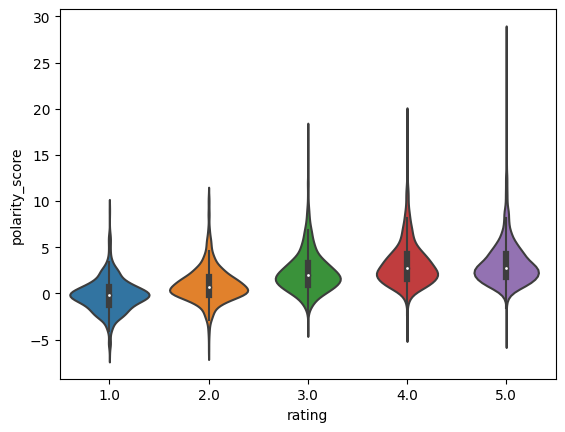

In [1]:
import spacy
import json
import pandas as pd
import seaborn as sns
from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

rev_ids = []
polarities = []
ratings = []

with open('yelp_academic_dataset_review_Nov2022_small.jsonl', 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        yelp = json.loads(line)

        review = yelp['text']
        rating = yelp['stars']
        rev_id = yelp['review_id']

        yelp_text = nlp(review)
        polarity = 0
        for sent in yelp_text._.blob.sentiment_assessments.assessments:
            polarity += sent[1]
        
        rev_ids.append(rev_id)
        polarities.append(polarity)
        ratings.append(rating)

yelp_df = pd.DataFrame(columns=['review_id', 'rating', 'polarity_score'])
yelp_df['review_id'] = rev_ids
yelp_df['rating'] = ratings
yelp_df['polarity_score'] = polarities


sns.violinplot(data=yelp_df, x='rating', y='polarity_score')

### We see higher polarity scores as ratings increase, in-line with the expectation that higher-rated reviews are more positive. We also notice a higher level of dispersion as ratings increase.

## Task 2. Each review in the dataset has its subjective phrases extracted, alongside information regarding ratings and id. These subjective phrases are then vectorized using spaCy's in-built vectorizer. 8 target reviews act as points of reference for similarity measures on other reviews.

In [2]:
import spacy
import json
import pandas as pd
import seaborn as sns
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

rev_ids = []
polarities = []
ratings = []
subj_phrases = []
vector_indices = []
reviews = []
ineligible_titles = []
target_review_ids = ["40thYphUgIfvJq17QCfTwA", "E9AB7V4z8xrt2uPF7T55FQ", "4PHFo_GRG4FEk1q4X7xQVQ",
                     "4KpIldEM-tdnrJLqYzRfZQ", "PDHRlnEdkEcwATry4w71PQ", "meGaFP7yxQdjyABrYDVeoQ",
                     "pgESDcC7eDx4z_epqon4_Q", "qeSxL-POvGLZD6aQ5O9kvw"]
target_ids = []

with open('yelp_academic_dataset_review_Nov2022_small.jsonl', 'r', encoding='utf-8') as f:
    for pos, line in enumerate(tqdm(f)):
        yelp = json.loads(line)

        review = yelp['text']
        rating = yelp['stars']
        rev_id = yelp['review_id']
        
        spacy_encoding = np.array([float(0) for i in range(96)])
        token_count = 0
        yelp_text = nlp(review)
        phrase = []
        polarity = 0
        
        for sent in yelp_text._.blob.sentiment_assessments.assessments:
            phrase.append(' '.join(sent[0]))
            for token in nlp(' '.join(sent[0])):
                token_count += 1
                spacy_encoding += np.array(token.vector)
            polarity += sent[1]
        
        if token_count > 0:
            spacy_encoding /= token_count
            vector_indices.append(spacy_encoding)
        else:
            ineligible_titles.append(pos)
            vector_indices.append(np.nan)
        
        if rev_id in target_review_ids:
            target_ids.append(pos)
        rev_ids.append(rev_id)
        polarities.append(polarity)
        ratings.append(rating)
        subj_phrases.append(phrase)
        reviews.append(yelp_text.text)

10000it [07:30, 22.21it/s]


In [3]:
from scipy.spatial.distance import cosine

yelpsim = pd.DataFrame(columns=['review_id', 'rating', 'polarity_score', 'review_text'])
yelpsim['review_id'] = rev_ids
yelpsim['rating'] = ratings
yelpsim['polarity_score'] = polarities
yelpsim['review_text'] = reviews

for targets in target_ids:
    simvec = []
    for i in tqdm(range(0, len(rev_ids))):
        if i in ineligible_titles or i == targets:
            simvec.append(np.nan)
        else:
            simvec.append(1 - cosine(vector_indices[targets], vector_indices[i]))
    
    title = 'comp to ' + str(targets)
    yelpsim[title] = simvec

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 51009.52it/s]


In [4]:
for targets in target_ids:
    print(f'review of comparison: {reviews[targets]}')
    print(f"phrases of comparison: {subj_phrases[targets]}")
    print(f"rating of comparison: {ratings[targets]}")
    title = 'comp to ' + str(targets)
    print(yelpsim.sort_values(by=[title],ascending=False)[['review_text','rating',title]].head(3))
    print("\n")

review of comparison: Great staff always helps and always nice. Always clean and huge store size. Stays stocked with everything you need. The staff always helps make my custom breakfast bagel
phrases of comparison: ['great', 'nice', 'clean', 'huge']
rating of comparison: 5.0
                                            review_text  rating  comp to 32
8542  Great food good times if your looking  for a g...     5.0    0.965837
9591  Nice lounge, cool atmosphere great lighting.  ...     4.0    0.964701
1753  Nice scenery of nature. Great trail for runnin...     4.0    0.962683


review of comparison: Amazing biscuits and (fill in the blank). Great cocktails too. Highly recommended. A bit busy though.
phrases of comparison: ['amazing', 'blank', 'great', 'highly', 'busy']
rating of comparison: 5.0
                                            review_text  rating  comp to 39
2302  I could not be happier with choosing the Rivie...     5.0    0.946465
6649  The ambiance and live music here is fan

### For each review used as a point of reference, the top 3 most similar review texts are listed, alongside their rating. While not uncommon to see the rating of the initial review correspond to the rating of the most similar texts, we also find that the ratings are not necessarily correlated. This may be an outcome of a) the variability in rating ascription given to a sentiment by different people (e.g. 'business' -- sometimes not an issue, sometimes a 'break it') and/or b) sentiment phrases used in areas unrelated to the core of the rating assessment. For example, with regards to this latter point, looking at at reference review #2, we find that review-id 'pciKtFPjpBOXaBSdSK2VDQ' (or index 6649) uses similar sentiments to characterize the venue, the live music, and its ambiance ('amazing', 'great', 'busy'), but that the core contention of the review (and its 1.0 rating) focuses exclusively on the experience with food service and staff. 